In [19]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,Dropout, Flatten, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder # one-hot encoding for age
from keras.utils import to_categorical

from PIL import Image 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

image_path = ''

In [20]:
df = pd.read_csv('data_tokenized_2609_doctr_trad V2', sep = '\t')
df.head()

,filename,type,size,width,height,mots_doctr,nb_mots,mots_concat,Langue,mots_doctr_trad
0,img_0000000.jpg,facture,59453,750,1061,"['factur', 'logo', 'joanner', 'binet', 'couber...",55,factur logo joanner binet coubertin pari factu...,fr,"['bill', 'logo', 'joanner', 'binet', 'couberti..."
1,img_0000001.jpg,facture,55157,750,1061,"['joanner', 'binet', 'coubertin', 'pari', 'fac...",53,joanner binet coubertin pari factur facturé ce...,fr,"['joanner', 'binet', 'coubertine', 'bet', 'bil..."
2,img_0000002.jpg,facture,32097,726,1024,"['factur', 'entreprise', 'nom', 'société', 'ad...",28,factur entreprise nom société adresse postal a...,fr,"['bill', 'enterprise', 'name', 'company', 'Add..."
3,img_0000003.jpg,facture,63937,750,1061,"['joanner', 'binet', 'coubertin', 'pari', 'fac...",53,joanner binet coubertin pari factur cendrillon...,fr,"['joanner', 'binet', 'coubertine', 'bet', 'bil..."
4,img_0000004.jpg,facture,79474,773,771,"['payer', 'ligne', 'factur', 'sfideli', 'date'...",63,payer ligne factur sfideli date création date ...,fr,"['pay', 'line', 'bill', 'sfideli', 'date', 'es..."


In [21]:
df_temp = df.sample(n=6)['filename']

/tmp/ipykernel_4429/681065927.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(number_of_images/2,2,i+1)


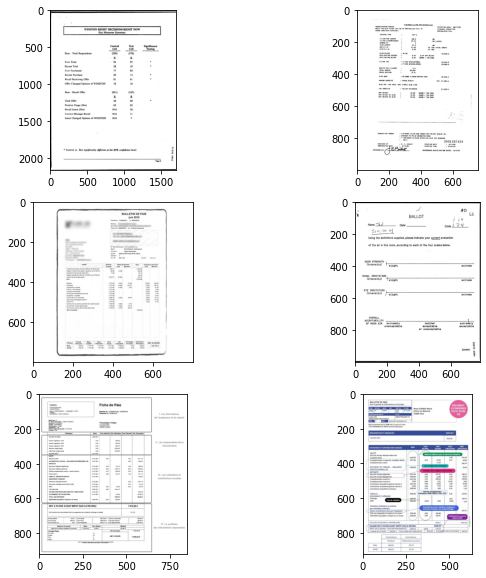

In [22]:
number_of_images = 6
plt.figure(figsize=(10,10))
for i in range(number_of_images):
    file = mpimg.imread(df_temp.iloc[i])
    plt.subplot(number_of_images/2,2,i+1)
    plt.imshow(file)

In [23]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df['type'] = le.fit_transform(df['type'])

In [24]:
le.classes_

array(['advertisement', 'budget', 'carte postale', 'email', 'facture',
       'form', 'handwritten', 'id_pieces', 'invoice', 'justif_domicile',
       'letter', 'memo', 'news_article', 'passeport', 'paye',
       'presentation', 'questionnaire', 'resume', 'rrc.cvc',
       'scientific_publication', 'scientific_report', 'specification'],
      dtype=object)

In [25]:
X = []
Y = []
width = 100
height = 100

for index, value in enumerate(df.filename):
    file_path = value
    image = Image.open(file_path)
    image = image.convert('RGB')
    image = image.resize((width, height))
    X.append(np.array(image))
    Y.append(df.iloc[index]['type'])

In [26]:
X = np.array(X)
X = X.astype('float32')
X /=255.0

Y = np.array(Y)

In [27]:
Y.shape

(1134,)

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.3, random_state = 42, shuffle = True, stratify = Y)

type =  paye


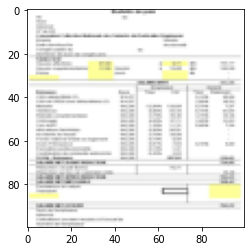

In [29]:
print('type = ', le.classes_[Y_train[2]])
plt.imshow(X_train[2])
plt.show()

In [30]:
train_datagen = ImageDataGenerator(
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2,
    horizontal_flip = True) # randomly flipping half of the images horizontally

test_datagen = ImageDataGenerator()

In [31]:
train_dataset = train_datagen.flow(X_train,Y_train,
                         batch_size = 128)


test_dataset = test_datagen.flow(X_test, Y_test, batch_size = 128) 

In [32]:
from tensorflow.keras.callbacks import Callback
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [33]:
#Insérez votre code ici
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0.01,
                              patience = 5,
                              verbose = 1)

reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                                        min_delta = 3,
                                        patience = 3,
                                        factor = 0.1,
                                        cooldown = 4,
                                        verbose = 1)

time_callback = TimingCallback()

In [34]:
#Instanciation du modèle 
model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),activation="relu",
                padding="valid",
                kernel_regularizer=regularizers.l2(0.00001),
                input_shape=(100, 100, 3)))

model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(22,activation="softmax")) 

In [35]:
#Compilation du modèle
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=['acc'])

In [36]:
#Entrainement du modèle, utiliser le jeu de données augmenté, et préciser les callbacks 

batch_size = 128
epochs = 30 
model_history = model.fit_generator(
            train_dataset, # use augmented images for train 
            steps_per_epoch=X_train.shape[0] // batch_size,
            validation_data = test_dataset, # use augmented images for test
            epochs = epochs,
            callbacks = [
                         reduce_learning_rate,
                         early_stopping,
                         time_callback
                        ],
            verbose=True)

Epoch 1/30


/tmp/ipykernel_4429/406433912.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


6/6 [==============================] - 1s 195ms/step - loss: 6.7264 - acc: 0.1173 - val_loss: 4.8148 - val_acc: 0.1290 - lr: 0.0010
Epoch 2/30
6/6 [==============================] - 1s 174ms/step - loss: 4.2079 - acc: 0.2030 - val_loss: 3.2567 - val_acc: 0.2962 - lr: 0.0010
Epoch 3/30
6/6 [==============================] - 1s 207ms/step - loss: 2.6844 - acc: 0.3068 - val_loss: 2.6323 - val_acc: 0.2903 - lr: 0.0010
Epoch 4/30
6/6 [==============================] - ETA: 0s - loss: 2.4313 - acc: 0.3143
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
6/6 [==============================] - 1s 176ms/step - loss: 2.4313 - acc: 0.3143 - val_loss: 2.6370 - val_acc: 0.2845 - lr: 0.0010
Epoch 5/30
6/6 [==============================] - 1s 207ms/step - loss: 2.3791 - acc: 0.3383 - val_loss: 2.5232 - val_acc: 0.3196 - lr: 1.0000e-04
Epoch 6/30
6/6 [==============================] - 1s 174ms/step - loss: 2.3063 - acc: 0.3534 - val_loss: 2.4670 - val_acc: 0.3167 - lr: 1.0

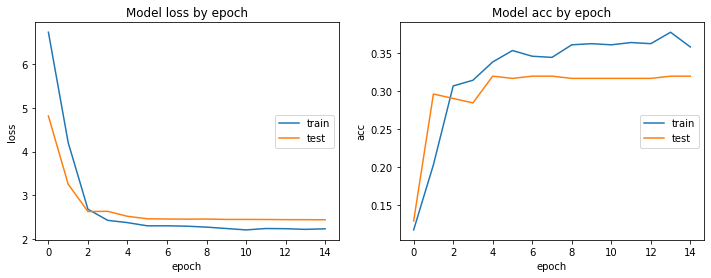

In [37]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()



On essaye d'améliorer les résultats avec le modele vgg16.

In [38]:

from tensorflow.keras.applications.vgg16 import preprocess_input

train_data_generator = ImageDataGenerator(
        preprocessing_function = preprocess_input,
        # data augmentation
        rotation_range = 10,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        zoom_range = 1.1,
        horizontal_flip = True
        )

test_data_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input)


In [39]:

train_datagen = ImageDataGenerator(
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2,
    horizontal_flip = True) # randomly flipping half of the images horizontally

test_datagen = ImageDataGenerator()

train_dataset = train_datagen.flow(X_train,Y_train,
                         batch_size = 128)


test_dataset = test_datagen.flow(X_test, Y_test, batch_size = 128) 

In [40]:
from tensorflow.keras.applications.vgg16 import VGG16

n_class=22
# Modèle VGG16
base_model = VGG16(weights='imagenet', include_top=False) 
# Freezer les couches du VGG16
for layer in base_model.layers: 
    layer.trainable = False

model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(GlobalAveragePooling2D()) 
model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(n_class, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])


In [43]:
## Insérez votre code ici
batch_size = 128

history = model.fit_generator(generator = train_dataset, 
                                epochs = 30,
                                steps_per_epoch = X_train.shape[0]//batch_size,
                                validation_data = test_dataset,
                                validation_steps = X_test.shape[0]//batch_size
                                )


Epoch 1/30


/tmp/ipykernel_4429/1250279822.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_dataset,


6/6 [==============================] - 20s 3s/step - loss: 2.2400 - acc: 0.3639 - val_loss: 2.1332 - val_acc: 0.4102
Epoch 2/30
6/6 [==============================] - 19s 3s/step - loss: 2.1499 - acc: 0.4120 - val_loss: 2.1086 - val_acc: 0.4180
Epoch 3/30
6/6 [==============================] - 19s 3s/step - loss: 2.0879 - acc: 0.4195 - val_loss: 2.0555 - val_acc: 0.3945
Epoch 4/30
6/6 [==============================] - 22s 4s/step - loss: 2.0161 - acc: 0.4076 - val_loss: 1.9284 - val_acc: 0.4414
Epoch 5/30
6/6 [==============================] - 22s 4s/step - loss: 1.9040 - acc: 0.4391 - val_loss: 1.9825 - val_acc: 0.4141
Epoch 6/30
6/6 [==============================] - 22s 4s/step - loss: 1.8778 - acc: 0.4511 - val_loss: 1.9703 - val_acc: 0.4375
Epoch 7/30
6/6 [==============================] - 22s 4s/step - loss: 1.8778 - acc: 0.4286 - val_loss: 1.9715 - val_acc: 0.4297
Epoch 8/30
6/6 [==============================] - 21s 4s/step - loss: 1.8132 - acc: 0.4812 - val_loss: 1.8248 - val

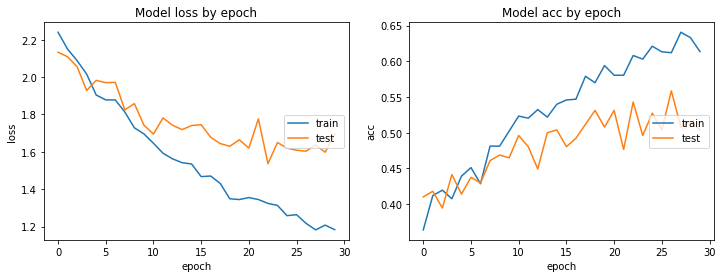

In [44]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()


On defreeze les 4 derniers layers du modèle.

In [45]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

In [48]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(generator=train_dataset, 
                                epochs = 10,
                                steps_per_epoch = X_train.shape[0]//batch_size,
                                validation_data=test_dataset,
                                validation_steps=X_test.shape[0]//batch_size
                                )


Epoch 1/10


/tmp/ipykernel_4429/2710446682.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_dataset,


6/6 [==============================] - 24s 4s/step - loss: 9.5917 - accuracy: 0.2513 - val_loss: 3.2499 - val_accuracy: 0.0664
Epoch 2/10
6/6 [==============================] - 22s 4s/step - loss: 3.1472 - accuracy: 0.2150 - val_loss: 3.0483 - val_accuracy: 0.2578
Epoch 3/10
6/6 [==============================] - 21s 4s/step - loss: 2.9378 - accuracy: 0.1188 - val_loss: 2.6947 - val_accuracy: 0.2617
Epoch 4/10
6/6 [==============================] - 22s 4s/step - loss: 2.8414 - accuracy: 0.2195 - val_loss: 2.8731 - val_accuracy: 0.2969
Epoch 5/10
6/6 [==============================] - 21s 4s/step - loss: 2.8163 - accuracy: 0.2887 - val_loss: 2.6431 - val_accuracy: 0.2695
Epoch 6/10
6/6 [==============================] - 20s 3s/step - loss: 2.7652 - accuracy: 0.2556 - val_loss: 2.5848 - val_accuracy: 0.2578
Epoch 7/10
6/6 [==============================] - 21s 4s/step - loss: 2.5423 - accuracy: 0.2992 - val_loss: 2.4204 - val_accuracy: 0.3164
Epoch 8/10
6/6 [=============================

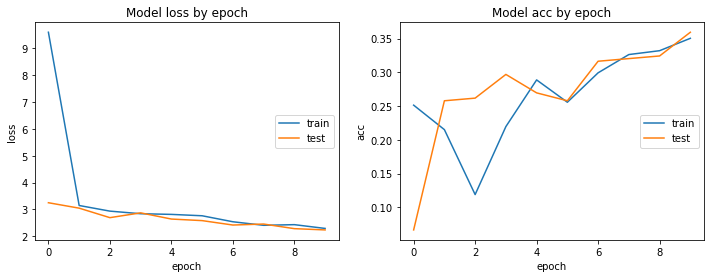

In [49]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()


On essaye le modèle efficientnet

In [50]:
import efficientnet.keras as efn

In [51]:
X = []
Y = []
width = 100
height = 100

for index, value in enumerate(df.filename):
    file_path = value
    image = Image.open(file_path)
    image = image.convert('RGB')
    image = image.resize((width, height))
    X.append(np.array(image))
    Y.append(df.iloc[index]['type'])

In [52]:
X = np.array(X)
X = X.astype('float32')
X /=255.0

Y = np.array(Y)

In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.3, random_state = 42, shuffle = True, stratify = Y)

In [54]:
train_datagen = ImageDataGenerator(
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2,
    horizontal_flip = True)# randomly flipping half of the images horizontally

test_datagen = ImageDataGenerator()

In [55]:
train_dataset = train_datagen.flow(X_train,Y_train,
                         batch_size = 128)


test_dataset = test_datagen.flow(X_test, Y_test, batch_size = 128) 

In [56]:
import tensorflow as tf
from keras.optimizers import Adam, SGD

input_shape = (100,100,3)
n_classes = 22
efnb0 = efn.EfficientNetB0(weights = 'imagenet', include_top = False, classes = n_classes, input_shape = input_shape) 

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation = 'softmax'))

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 4, 4, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_5 (Dense)             (None, 22)                28182     
                                                                 
Total params: 4,077,746
Trainable params: 4,035,730
Non-trainable params: 42,016
_________________________________________________________________


In [57]:
efnb0.trainable = False

In [58]:
model.compile(optimizer=Adam(lr=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/home/clement/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [59]:
history = model.fit_generator(generator=train_dataset, 
                                epochs = 30,
                                steps_per_epoch = X_train.shape[0]//128,
                                validation_data=test_dataset,
                                validation_steps=X_test.shape[0]//128
                                )

Epoch 1/30


/tmp/ipykernel_4429/3579034707.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_dataset,


6/6 [==============================] - 6s 598ms/step - loss: 2.9426 - accuracy: 0.1429 - val_loss: 2.7161 - val_accuracy: 0.1562
Epoch 2/30
6/6 [==============================] - 3s 444ms/step - loss: 2.6859 - accuracy: 0.2346 - val_loss: 2.5916 - val_accuracy: 0.2812
Epoch 3/30
6/6 [==============================] - 3s 431ms/step - loss: 2.5560 - accuracy: 0.2632 - val_loss: 2.5216 - val_accuracy: 0.2852
Epoch 4/30
6/6 [==============================] - 3s 446ms/step - loss: 2.4806 - accuracy: 0.2962 - val_loss: 2.4455 - val_accuracy: 0.3203
Epoch 5/30
6/6 [==============================] - 3s 451ms/step - loss: 2.3712 - accuracy: 0.3308 - val_loss: 2.3952 - val_accuracy: 0.3555
Epoch 6/30
6/6 [==============================] - 3s 515ms/step - loss: 2.2906 - accuracy: 0.3564 - val_loss: 2.2841 - val_accuracy: 0.3711
Epoch 7/30
6/6 [==============================] - 3s 450ms/step - loss: 2.2493 - accuracy: 0.3579 - val_loss: 2.2769 - val_accuracy: 0.3750
Epoch 8/30
6/6 [===============

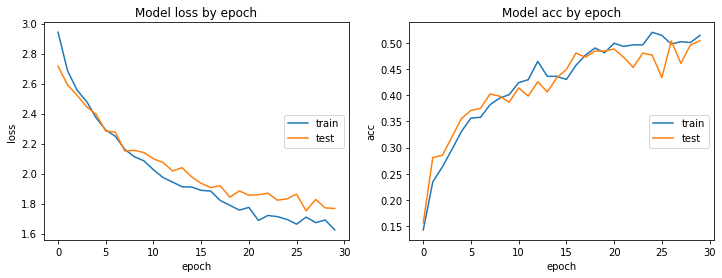

In [60]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

On essaye avec le modèle avec efnb0.trainable = True

In [61]:
efnb0.trainable = True

In [62]:
model.compile(optimizer=Adam(lr=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [63]:
history = model.fit_generator(generator=train_dataset, 
                                epochs = 50,
                                steps_per_epoch = X_train.shape[0]//128,
                                validation_data=test_dataset,
                                validation_steps=X_test.shape[0]//128
                                )

Epoch 1/50


/tmp/ipykernel_4429/279800059.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_dataset,


6/6 [==============================] - 12s 1s/step - loss: 2.5526 - accuracy: 0.2812 - val_loss: 2.2278 - val_accuracy: 0.3516
Epoch 2/50
6/6 [==============================] - 7s 1s/step - loss: 1.4699 - accuracy: 0.5820 - val_loss: 1.9663 - val_accuracy: 0.3945
Epoch 3/50
6/6 [==============================] - 7s 1s/step - loss: 1.1162 - accuracy: 0.6797 - val_loss: 1.8044 - val_accuracy: 0.4570
Epoch 4/50
6/6 [==============================] - 8s 1s/step - loss: 0.8734 - accuracy: 0.7422 - val_loss: 1.9233 - val_accuracy: 0.4453
Epoch 5/50
6/6 [==============================] - 7s 1s/step - loss: 0.6685 - accuracy: 0.7865 - val_loss: 2.1115 - val_accuracy: 0.4297
Epoch 6/50
6/6 [==============================] - 7s 1s/step - loss: 0.5584 - accuracy: 0.8256 - val_loss: 2.2491 - val_accuracy: 0.4141
Epoch 7/50
6/6 [==============================] - 7s 1s/step - loss: 0.4449 - accuracy: 0.8692 - val_loss: 2.2171 - val_accuracy: 0.4453
Epoch 8/50
6/6 [==============================] - 7

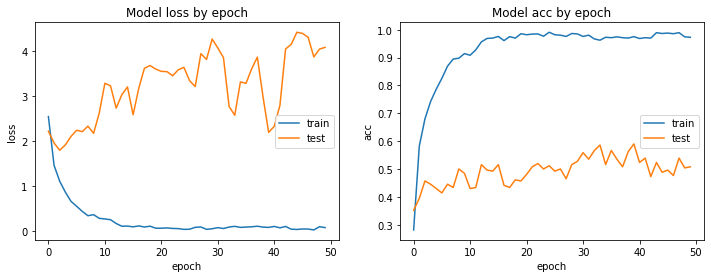

In [64]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [75]:
from sklearn import metrics

test_pred = model.predict(X_test)
test_pred_class = test_pred.argmax(axis = 1)

print(metrics.classification_report(Y_test, test_pred_class, target_names = le.classes_))


11/11 [==============================] - 1s 102ms/step
                        precision    recall  f1-score   support

         advertisement       0.43      0.43      0.43         7
                budget       1.00      0.14      0.25         7
         carte postale       0.63      0.57      0.60        21
                 email       1.00      0.14      0.25         7
               facture       0.67      0.20      0.31        20
                  form       1.00      0.14      0.25         7
           handwritten       0.21      0.55      0.30        11
             id_pieces       0.69      1.00      0.82        25
               invoice       0.00      0.00      0.00         7
       justif_domicile       1.00      0.14      0.25         7
                letter       1.00      0.11      0.20         9
                  memo       0.00      0.00      0.00         9
          news_article       1.00      0.30      0.46        10
             passeport       0.59      0.77     

/home/clement/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/clement/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/clement/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


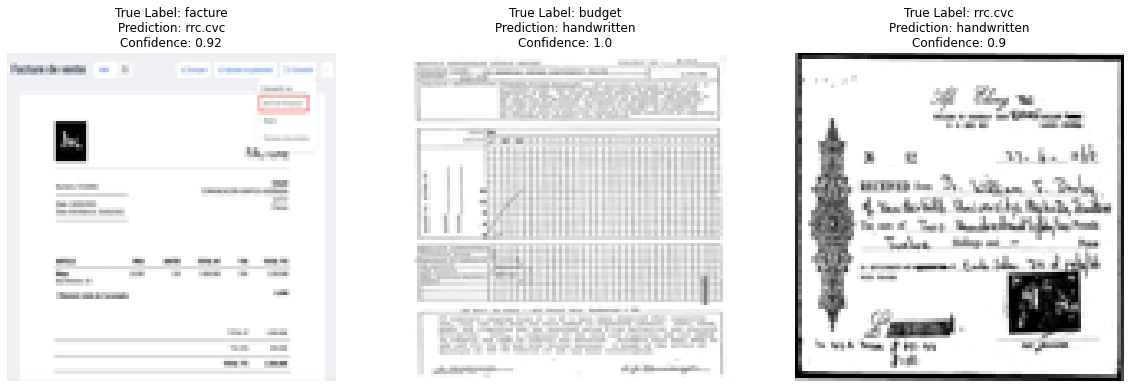

In [77]:
from matplotlib import cm


error_indexes = []
for i in range(len(test_pred)):
    if (test_pred_class[i] != Y_test[i]):
                error_indexes += [i]

plt.figure(figsize=(20,10))

j = 1
for i in np.random.choice(error_indexes, size = 3):
    img = X_test[i] 
    
    plt.subplot(1, 3, j)
    j = j + 1
    plt.axis('off')
    plt.imshow(img, cmap=cm.binary, interpolation='None')
    plt.title('True Label: ' + str(le.classes_[Y_test[i]]) \
              + '\n' + 'Prediction: '+ str(le.classes_[test_pred_class[i]]) \
              + '\n' + 'Confidence: '+ str(round(test_pred[i][test_pred_class[i]], 2)))
    


On modifie la fonction train_generator est utilisant la fonction flow_from_dataframe pour pouvoir plus facilement augmenter la taille des images.

In [81]:
df = pd.read_csv('data_tokenized_2609_doctr_trad V2', sep = '\t')
df.head()

,filename,type,size,width,height,mots_doctr,nb_mots,mots_concat,Langue,mots_doctr_trad
0,img_0000000.jpg,facture,59453,750,1061,"['factur', 'logo', 'joanner', 'binet', 'couber...",55,factur logo joanner binet coubertin pari factu...,fr,"['bill', 'logo', 'joanner', 'binet', 'couberti..."
1,img_0000001.jpg,facture,55157,750,1061,"['joanner', 'binet', 'coubertin', 'pari', 'fac...",53,joanner binet coubertin pari factur facturé ce...,fr,"['joanner', 'binet', 'coubertine', 'bet', 'bil..."
2,img_0000002.jpg,facture,32097,726,1024,"['factur', 'entreprise', 'nom', 'société', 'ad...",28,factur entreprise nom société adresse postal a...,fr,"['bill', 'enterprise', 'name', 'company', 'Add..."
3,img_0000003.jpg,facture,63937,750,1061,"['joanner', 'binet', 'coubertin', 'pari', 'fac...",53,joanner binet coubertin pari factur cendrillon...,fr,"['joanner', 'binet', 'coubertine', 'bet', 'bil..."
4,img_0000004.jpg,facture,79474,773,771,"['payer', 'ligne', 'factur', 'sfideli', 'date'...",63,payer ligne factur sfideli date création date ...,fr,"['pay', 'line', 'bill', 'sfideli', 'date', 'es..."


In [82]:
train_df = df.sample(frac = 0.8)
train_df = train_df[['filename','type']]

test_df = df.drop(train_df.index)
test_df = test_df[['filename', 'type']]

In [83]:
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2,
    horizontal_flip = True) # randomly flipping half of the images horizontally

test_datagen = ImageDataGenerator()

In [84]:
batch_size = 32
src_path_train = ''
src_path_test = ''

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=src_path_train,
    x_col="filename",
    y_col="type",
    target_size=(200, 200),
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)



test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=src_path_test,
    x_col="filename",
    target_size=(200, 200),
    batch_size=1,
    class_mode=None,
    shuffle=False,
)

Found 907 validated image filenames belonging to 22 classes.
Found 227 validated image filenames.


In [85]:
import tensorflow as tf
from keras.optimizers import Adam, SGD
import efficientnet.keras as efn

input_shape = (200,200,3)
n_classes = 22
efnb0 = efn.EfficientNetB0(weights = 'imagenet', include_top = False, classes = n_classes, input_shape = input_shape) 

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation = 'softmax'))

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 22)                28182     
                                                                 
Total params: 4,077,746
Trainable params: 4,035,730
Non-trainable params: 42,016
_________________________________________________________________


In [86]:
efnb0.trainable = True

In [87]:
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

/home/clement/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [89]:
history = model.fit_generator(train_generator,
                    validation_data = train_generator,
                    steps_per_epoch = test_generator.n//train_generator.batch_size,
                    #validation_steps = test_generator.n//valid_generator.batch_size,
                    epochs=30)


/tmp/ipykernel_4429/3453784365.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/30
7/7 [==============================] - 32s 4s/step - loss: 2.5356 - accuracy: 0.2857 - val_loss: 2.9914 - val_accuracy: 0.1544
Epoch 2/30
7/7 [==============================] - 26s 4s/step - loss: 1.6431 - accuracy: 0.5580 - val_loss: 2.8912 - val_accuracy: 0.1963
Epoch 3/30
7/7 [==============================] - 27s 4s/step - loss: 1.5699 - accuracy: 0.5670 - val_loss: 2.6496 - val_accuracy: 0.2789
Epoch 4/30
7/7 [==============================] - 27s 4s/step - loss: 1.3636 - accuracy: 0.6116 - val_loss: 2.2602 - val_accuracy: 0.3738
Epoch 5/30
7/7 [==============================] - 30s 5s/step - loss: 1.2293 - accuracy: 0.6429 - val_loss: 1.9925 - val_accuracy: 0.4322
Epoch 6/30
7/7 [==============================] - 28s 4s/step - loss: 1.0178 - accuracy: 0.7054 - val_loss: 1.8905 - val_accuracy: 0.4851
Epoch 7/30
7/7 [==============================] - 27s 4s/step - loss: 1.0445 - accuracy: 0.7054 - val_loss: 1.8778 - val_accuracy: 0.5017
Epoch 8/30
7/7 [==================

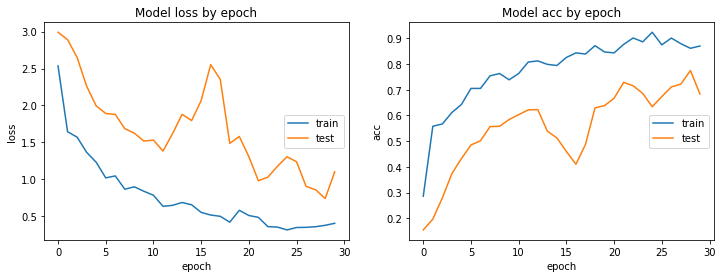

In [90]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

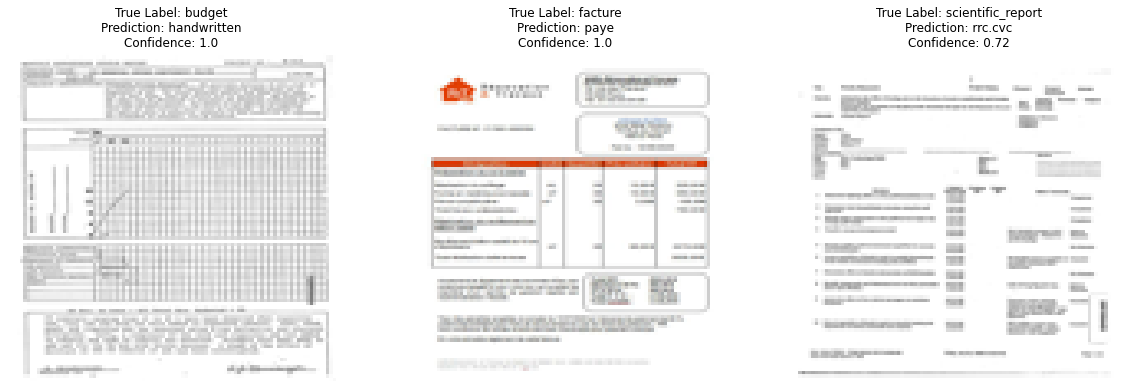

In [91]:
from matplotlib import cm


error_indexes = []
for i in range(len(test_pred)):
    if (test_pred_class[i] != Y_test[i]):
                error_indexes += [i]

plt.figure(figsize=(20,10))

j = 1
for i in np.random.choice(error_indexes, size = 3):
    img = X_test[i] 
    
    plt.subplot(1, 3, j)
    j = j + 1
    plt.axis('off')
    plt.imshow(img, cmap=cm.binary, interpolation='None')
    plt.title('True Label: ' + str(le.classes_[Y_test[i]]) \
              + '\n' + 'Prediction: '+ str(le.classes_[test_pred_class[i]]) \
              + '\n' + 'Confidence: '+ str(round(test_pred[i][test_pred_class[i]], 2)))
    
